# Examining fits of neurons in the brain-wide map

First let's do some data I/O, loading in our fits from a given date and looking at the distribution of D^2 scores by session:

In [34]:
from ipywidgets import interact
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import brainbox.io.one as bbone
import export_funs as ef

%matplotlib inline
fitdate = '2020-10-30'
fitfiles = [f'./fits/{subjdir}/{file}'
            for subjdir in os.listdir('./fits/') 
            for file in os.listdir(f'./fits/{subjdir}')
            if re.match(f'.*{fitdate}.*\.p', file)]
filedata = {}
for filename in fitfiles:
    data = np.load(filename, allow_pickle=True)
    filedata[filename] = data


In [35]:
observed_regions = []
for key, ses in filedata.items():
    unitdf = pd.Series(ses['fitobj'].clu_regions[ses['fitobj'].clu_ids.flat],
                       index=ses['fitobj'].clu_ids.flatten(), name='acronym')
    unitdf.index = unitdf.index.rename('cluster_id')
    ses['unit_regions'] = unitdf
    observed_regions.extend(unitdf.unique())
allregions = list(set(observed_regions))

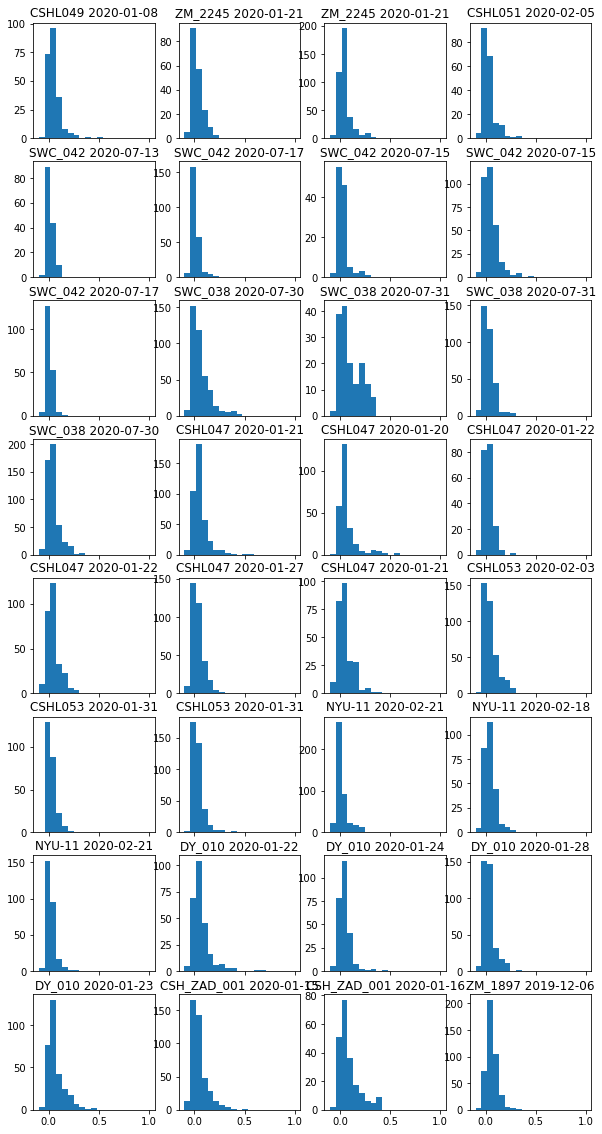

In [36]:
animals = list(set([filedata[s]['sessinfo']['subject_nickname'] for s in filedata]))

nsess = len(filedata)
fig, axes = plt.subplots(np.ceil(len(filedata) / 4).astype(int), 4, sharex=True, figsize=(10, nsess / 4 * 2.5))
axes = axes.flatten()
scorebins = np.linspace(-0.1, 1., 20)
for i, s in enumerate(filedata):
    scores = filedata[s]['fitobj'].submodel_scores
    sinfo = filedata[s]['sessinfo']
    axes[i].hist(scores['6cov'], bins=scorebins)
    axes[i].set_title(sinfo['subject_nickname'] + ' ' + str(sinfo['session_end_time'].date()))

In [39]:
from ibllib.atlas import regions_from_allen_csv
from ibllib.atlas import AllenAtlas
sess_strs = {s['sessinfo']['subject_nickname'] + ' from ' +
             str(s['sessinfo']['session_start_time'].date()) + ' probe: ' +
             str(s['sessinfo']['probe_idx']) : fn for fn, s in filedata.items()}
orig_fns = list(filedata.keys())
masterscores = []
noreg_masterscores = []
for i, fn in enumerate(filedata):
    scores = filedata[fn]['fitobj'].submodel_scores.copy()
    noreg_masterscores.append(scores.copy())
    regions = filedata[fn]['unit_regions']
    scores['acronym'] = regions
    scores['origfn'] = i
    scores = scores[pd.notna(scores['acronym'])]
    masterscores.append(scores)
masterscores = pd.concat(masterscores)
noreg_masterscores = pd.concat(noreg_masterscores)

brainregions = regions_from_allen_csv()
def get_parent_name(brainregion):
    regid = brainregions.id[np.argwhere(brainregions.acronym == brainregion)]
    ancestors = brainregions.ancestors(regid)
    targetlevel = 6
    if sum(ancestors.level == targetlevel) == 0:
        return ancestors.name[-1]
    return ancestors.name[np.argwhere(ancestors.level == targetlevel)[0, 0]]

def get_parent_acr(brainregion):
    regid = brainregions.id[np.argwhere(brainregions.acronym == brainregion)]
    ancestors = brainregions.ancestors(regid)
    targetlevel = 6
    if sum(ancestors.level == targetlevel) == 0:
        return ancestors.acronym[-1]
    return ancestors.acronym[np.argwhere(ancestors.level == targetlevel)[0, 0]]

masterscores['parent_name'] = masterscores['acronym'].apply(get_parent_name)
masterscores['parent_acronym'] = masterscores['acronym'].apply(get_parent_acr)
# masterscores['1covmax'] = masterscores.loc[:, 'correct':'wheel'].idxmax(axis=1)
masterscores.reset_index(inplace=True)
def sort_df(df):
    return pd.DataFrame(
        data=df.columns.values[np.argsort(-df.values, axis=1)],
        columns=['tag_{}'.format(i) for i in range(df.shape[1])])
sortcovs = sort_df(masterscores.loc[:, 'correct':'wheel'])
masterscores = pd.concat([masterscores, sortcovs], axis=1)

for i in range(1, 7):
    if i > 2:
        diff = masterscores[str(i) + 'cov'] - masterscores[str(i - 1) + 'cov']
    elif i == 2:
        diff = masterscores[str(i) + 'cov'] - masterscores.loc[:, 'correct':'wheel'].max(axis=1)
    else:
        diff = masterscores.loc[:, 'correct':'wheel'].max(axis=1)
    masterscores[str(i) + 'cov_diff'] = diff

remove = ['1', '2', '3', '4', '5', '6a', '6b', '/']
def combine_layers_cortex(regions, delete_duplicates=False):
    for i, region in enumerate(regions):
        for j, char in enumerate(remove):
            regions[i] = regions[i].replace(char, '')
    if delete_duplicates:
        regions = list(set(regions))
    return regions

def get_nolayer_name(brainregion):
    try:
        regname = brainregions.name[np.argwhere(brainregions.acronym == brainregion).flatten()][0]
        return regname
    except IndexError:
        return ''

masterscores['nolayer_acr'] = masterscores['acronym'].copy()
for remstr in remove:
    masterscores['nolayer_acr'] = masterscores['nolayer_acr'].str.replace(remstr, '')
masterscores['nolayer_name'] = masterscores.nolayer_acr.apply(get_nolayer_name)

rawpoints = masterscores.melt(id_vars=['tag_0', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'parent_name',
                                       'acronym', 'nolayer_acr', 'nolayer_name', 'parent_acronym'],
                              value_vars=['1cov_diff', '2cov_diff', '3cov_diff',
                                          '4cov_diff', '5cov_diff', '6cov_diff'],
                              ignore_index=False)
rawpoints['covname'] = rawpoints.apply(lambda x: x['tag_' + str(int(x.variable[0]) - 1)], axis=1)
rawpoints = rawpoints.drop(columns=['tag_0', 'tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5'])

ba = AllenAtlas(25)
all_regions = combine_layers_cortex(ba.regions.acronym)

<AxesSubplot:xlabel='variable'>

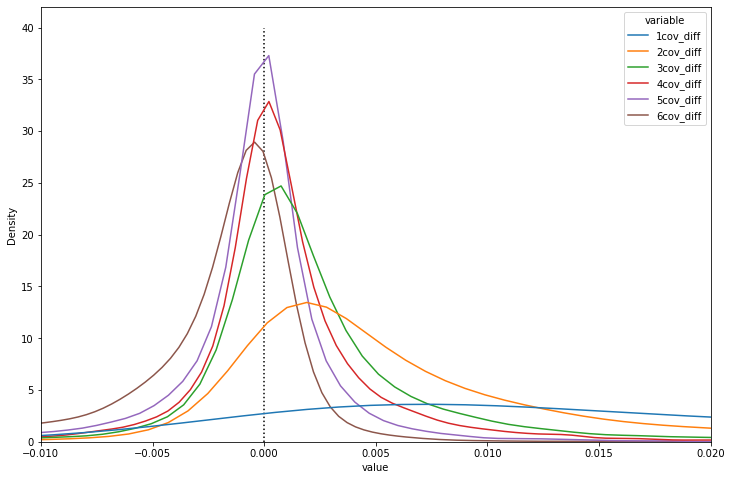

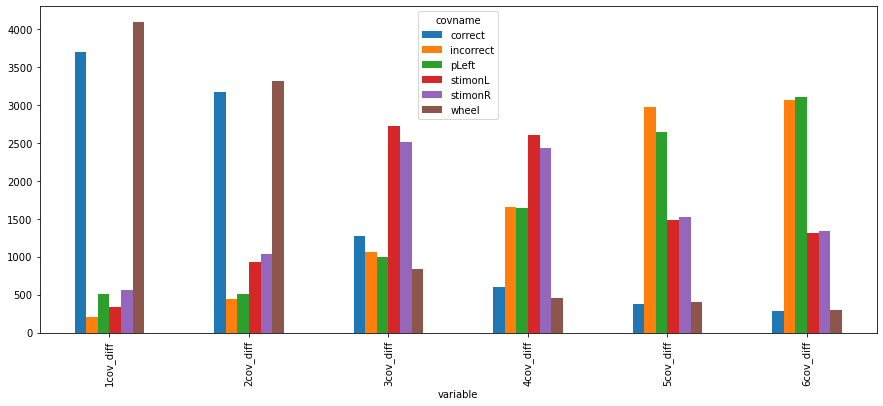

In [40]:
# Lets see how the distributions of delta Dsq change according to which position a kernel is added in:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=rawpoints[(rawpoints.value > -0.05) & (rawpoints.value < 0.2)], x='value', hue='variable')
ax = plt.gca()
ax.set_xlim([-0.01, 0.02])
ax.vlines(0, 0, 40, color='k', ls=':')

plt.figure(figsize=(15, 6))
ax = plt.gca()
rawpoints.groupby('variable').covname.value_counts().unstack().plot(kind='bar', ax=ax)

## Looking at fit characteristics by region

Next we would like to investigate the characteristics of single-neuron fits, conditioned by region. First, we will look at the $D^2$ (also known as pseudo-$R^2$) scores by region. We want to know for a given region:

1. What proportion of cells have a given kernel as the argmax for single-kernel $D^2$ scores, and what the distribution of scores for that kernel are given that it is the argmax kernel

2. Conditioned on a given first kernel, what the addtional explainability ($\Delta D^2$) is for each of the subsequent kernel options

In [11]:
%qtconsole

In [41]:
import plotly.express as px

min_cells = 20
regcounts = pd.value_counts(masterscores['parent_name'])
high_count_regs = regcounts[regcounts > min_cells].index
covars = masterscores.loc[:, 'correct':'wheel'].columns
singleparmelt = masterscores.melt(id_vars=['parent_name', 'tag_0'], value_vars=['correct', 'incorrect', 'pLeft', 'wheel', 'stimonL', 'stimonR'],
                            ignore_index=False)


@interact
def plot_region_summary(reg=high_count_regs, first_kern=covars):
    plt.close('all')
    regiondf = masterscores[masterscores.parent_name == reg]
    regionpoints = rawpoints[rawpoints.parent_name == reg]
    singlepar_max = regiondf.loc[:, 'correct':'wheel'].idxmax(axis=1)
    singlepar_maxcounts = singlepar_max.value_counts()
    top3 = singlepar_maxcounts.index[:3]
    topdf = regiondf[top3]
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 7), sharey=True)
    sns.boxplot(data=singleparmelt[singleparmelt.parent_name == reg], x='value', y='variable', orient='h',
                order=covars, ax=axes[0])
    axes[0].set_xlim([-0.05, 0.1])
    axes[0].vlines(0, axes[0].get_ylim()[0], axes[0].get_ylim()[1], color='k', ls=':')
    axes[0].set_title('Distribution of $D^2$ for each kernel (no condition)')
    
    topkern_scores = singleparmelt[(singleparmelt.tag_0 == singleparmelt.variable) & (singleparmelt.parent_name == reg)]
    sns.boxplot(data=topkern_scores, x='value', y='variable', orient='h', order=covars, ax=axes[1])
    axes[1].set_title('$D^2$ scores for kernels when that kernel is the argmax')
    axes[1].set_xlim([-0.05, 0.1])
    axes[1].vlines(0, axes[1].get_ylim()[0], axes[1].get_ylim()[1], color='k', ls=':')
    
    axes[2].barh(axes[1].get_yticks(), singlepar_maxcounts[list(covars)])
    axes[2].set_title('Number of units with each kernel as argmax')

    # Boxplot the subsequent combination of regressors up to 3
    cond_raw = rawpoints[np.isin(rawpoints.index, masterscores.index[(masterscores.parent_name == reg) & (masterscores.tag_0 == first_kern)])]
    cond_raw_2 = cond_raw[cond_raw.variable == '2cov_diff']
    fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=True)
    sns.boxplot(data=cond_raw_2, x='value', y='covname', order=covars, ax=axes[0])
    axes[0].vlines(0, axes[0].get_ylim()[0], axes[0].get_ylim()[1], color='k', linestyle=':')
    cond_2_vcounts = cond_raw_2.covname.value_counts()
    cond_2_vcounts[first_kern] = 0
    axes[0].set_title(r'$\Delta D^2$ for 1st additional regressor,' + '\ngiven first regressor is ' + first_kern)
    axes[1].barh(axes[1].get_yticks(), cond_2_vcounts[covars])
    axes[1].set_title('Number of units with each kernel as second argmax')
    return

interactive(children=(Dropdown(description='reg', options=('Hippocampal region', 'Somatomotor areas', 'Lateral…

Text(0.5, 1.0, 'Proportion of cells with argmax pLeft')

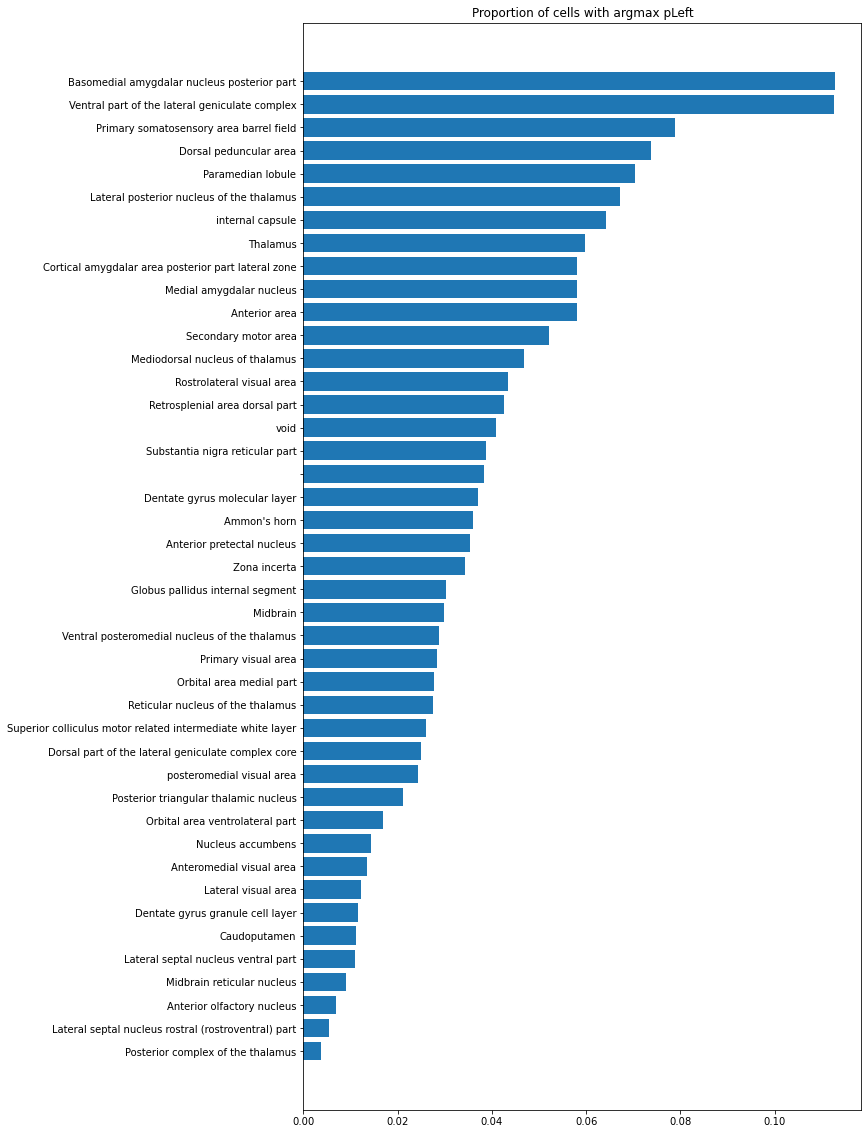

In [42]:
kern_name = 'pLeft'
grouper = 'nolayer_name'

topregions = masterscores[grouper].value_counts()
topregions = topregions[topregions > 60]

topreg_master = masterscores[np.isin(masterscores[grouper], topregions.index)].copy()
def drop_subzero_max(row):
    maxind = row.tag_0
    if row[maxind] < 0:
        row.tag_0 = 'None'
    return row

topreg_master = topreg_master.apply(drop_subzero_max, axis=1)
kern_props = topreg_master.groupby(grouper).tag_0.apply(pd.value_counts, normalize=True)
target_props = kern_props.loc[:, kern_name].sort_values()

plt.figure(figsize=(10, 20))
plt.barh(range(len(target_props)), target_props, tick_label=target_props.index)
plt.gca().set_title(f'Proportion of cells with argmax {kern_name}')


Text(0.5, 0, '$\\Delta D^2$')

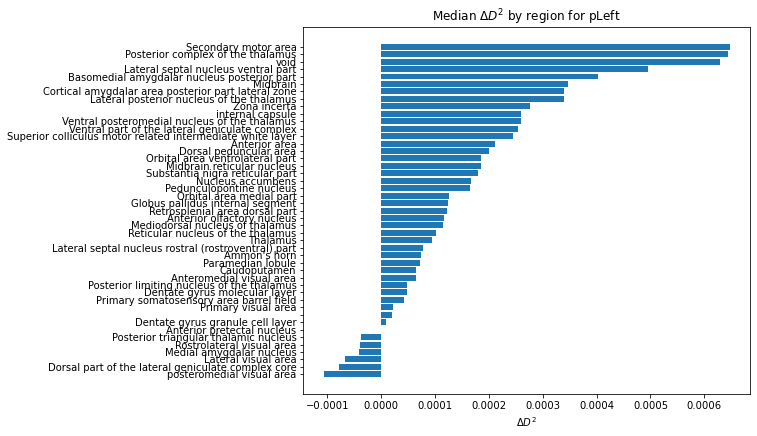

In [43]:
n_regions = 50
badinds = topreg_master.index[topreg_master.tag_0 == 'None']
topreg_melt = rawpoints[np.isin(rawpoints[grouper], topregions.index)].drop(index=badinds)
fig, ax = plt.subplots(1, 1, figsize=(8, len(topregions) * 0.15))
covmelt = topreg_melt[topreg_melt.covname == kern_name]
medians = covmelt.groupby(grouper).agg({'value':'median'}).sort_values('value', ascending=False)[:n_regions]
ax.barh(range(len(medians)), medians.values.flatten()[::-1], tick_label=medians.index[::-1])
ax.set_title(r'Median $\Delta D^2$ by region for' + f' {kern_name}')
ax.set_xlabel(r'$\Delta D^2$')

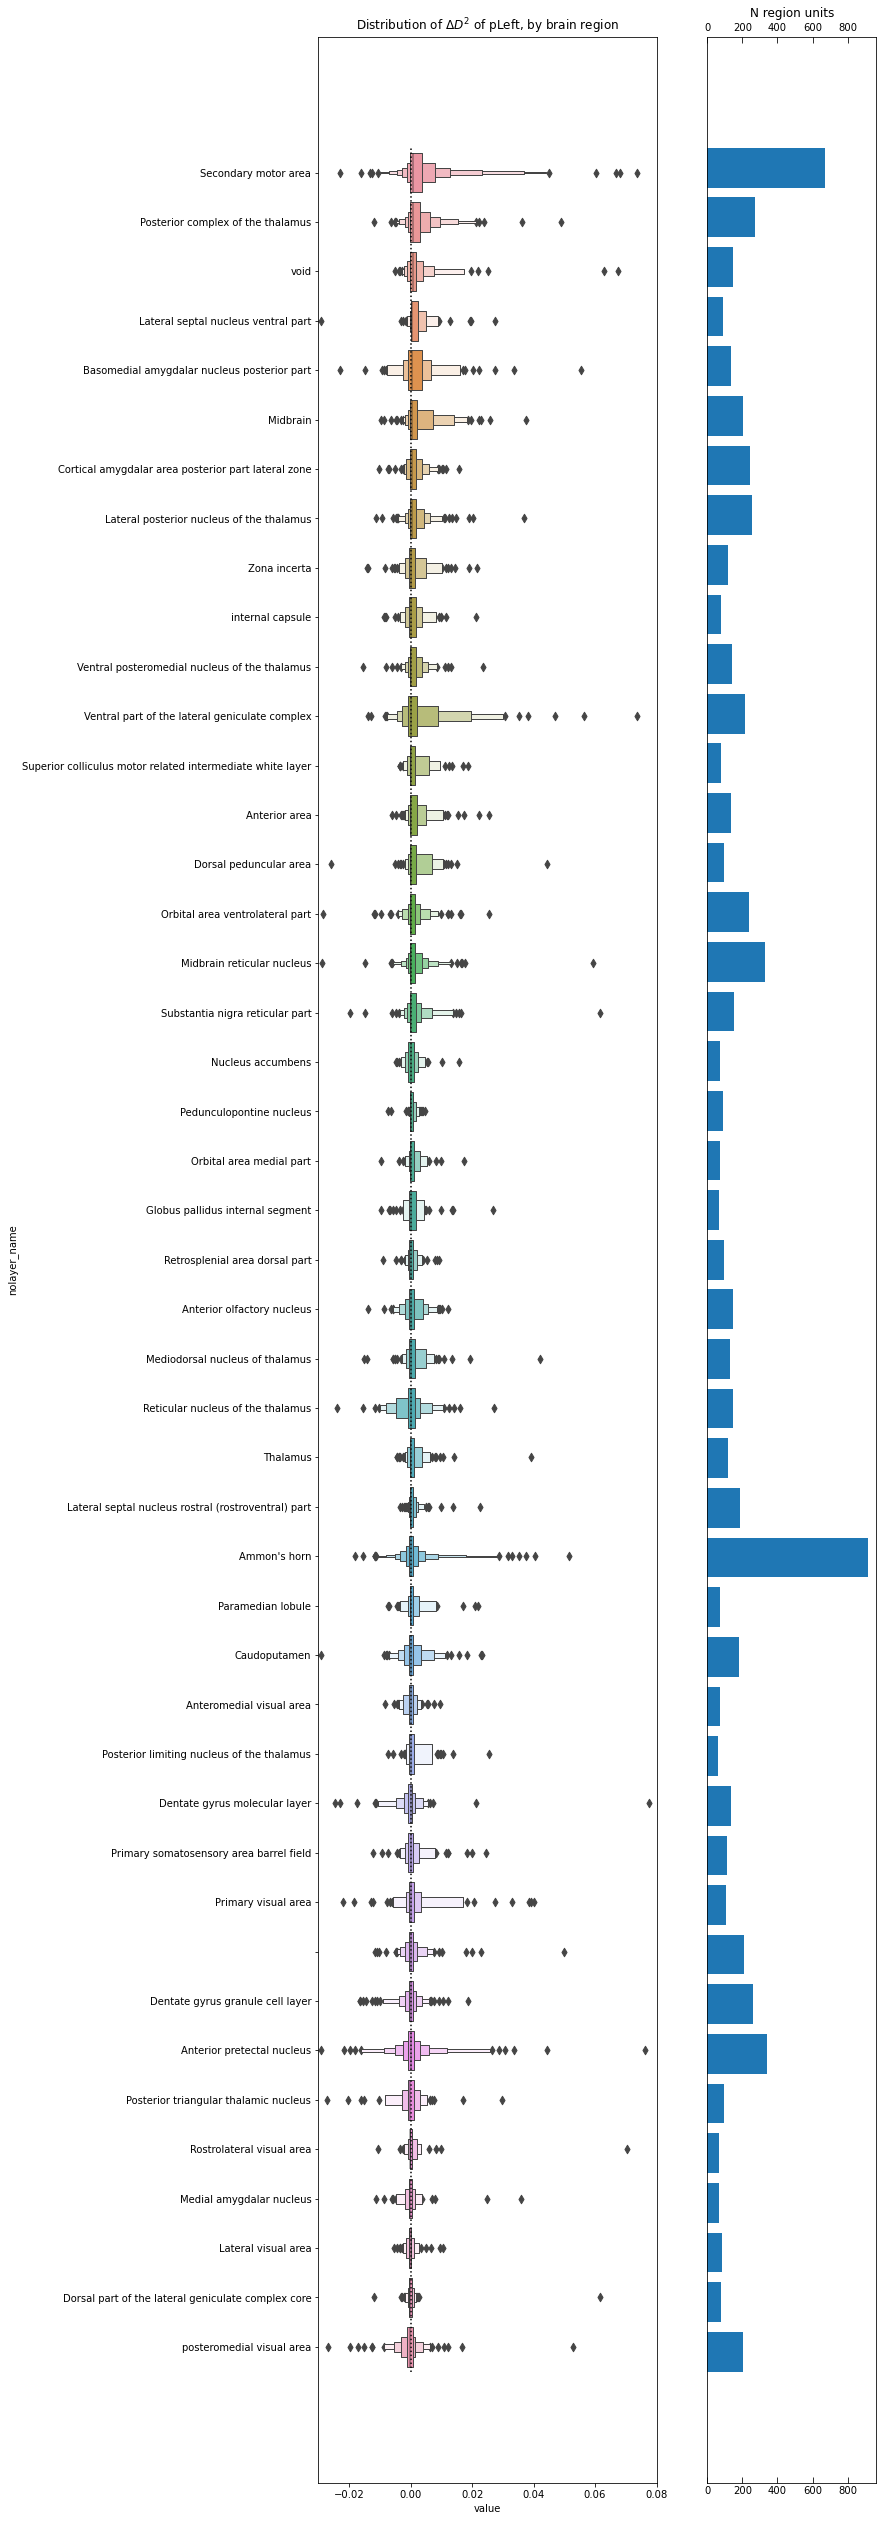

In [44]:
badinds = topreg_master.index[topreg_master.tag_0 == 'None']
topreg_melt = rawpoints[np.isin(rawpoints[grouper], topregions.index)].drop(index=badinds)
topreg_melt['group'] = topreg_melt['covname'].apply(lambda st: kern_name if st == kern_name else 'others')
regorder = topreg_melt[topreg_melt.covname == kern_name].groupby(grouper).agg({'value':'median'}).sort_values('value', ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(10, len(topregions)), gridspec_kw={'width_ratios': [2, 1]})
sns.boxenplot(data=topreg_melt[topreg_melt.group == kern_name], x='value', y=grouper,
#               hue='group', hue_order=[kern_name, 'others'],
              order=regorder, ax=ax[0])
if kern_name == 'correct':
    ax[0].set_xlim([-0.05, 0.50])
else:
    ax[0].set_xlim([-0.03, 0.08])
ax[0].vlines(0, ax[0].get_ylim()[0], ax[0].get_ylim()[1], color='k', ls=':')
ax[0].set_title(r'Distribution of $\Delta D^2$' + f' of {kern_name}, by brain region')
# ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=45)

ax[1].barh(ax[0].get_yticks(), topreg_master[grouper].value_counts().loc[regorder].iloc[::-1])
ax[1].set_yticks([])
ax[1].set_title('N region units')
ax[1].tick_params(labeltop=True, top=True, direction='in', length=6)

In [11]:
import ipywidgets as ipw
import brainbox.atlas as bbat

medians = rawpoints.groupby(['nolayer_acr', 'covname', 'variable']).agg({'value': 'mean'})
models = ['2cov_diff', '3cov_diff', '4cov_diff', '5cov_diff', '6cov_diff']
kernels = ['correct', 'incorrect', 'pLeft', 'wheel', 'stimonR', 'stimonL']

mlslider = ipw.FloatSlider(min=-5, max=5, step=0.01, value=0, description='Medial-Lateral axis (mm)')
apslider = ipw.FloatSlidwheeler(min=-5, max=5, step=0.01, value=0, description='Anterior-Posterior axis (mm)')
dvslider = ipw.FloatSlider(min=-0.1, max=8, step=0.01, value=2, description='Dorsal-Ventral axis (mm)')
@ipw.interact_manual
def delta_dsq_heatmap(model=models, kernel=kernels, ML=mlslider, AP=apslider, DV=dvslider):
    data = medians.loc[:, kernel, model]
    regions = data.index.to_numpy().reshape(-1)
#     print(set(regions))
    values = data.values.reshape(-1)
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    bbat.plot_atlas(regions, values, ML, AP, DV, axs=axes, custom_region_list=all_regions)
    plt.suptitle(f'Additional {kernel} contribution for the {model} model')
    return


AttributeError: module 'ipywidgets' has no attribute 'FloatSlidwheeler'

In [18]:
fw = open(f'/media/berk/Storage1/completefits_{fitdate}.p', 'wb')
filenames = list(filedata.keys())
output = {'masterscores': masterscores, 'rawpoints': rawpoints, 'file_names': filenames,
          'session_uuids': [str(filedata[fn]['sessinfo']['session_uuid']) for fn in filenames]}
pickle.dump(output, fw)
fw.close()

(-0.05, 0.15)

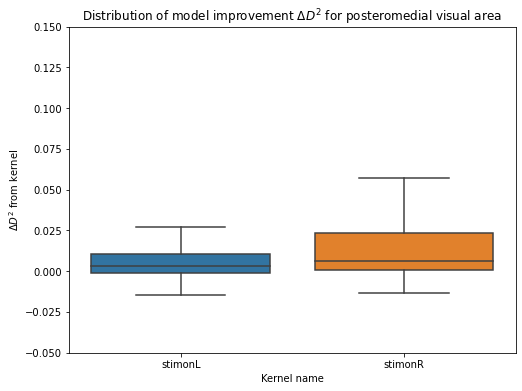

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.boxplot(data=topreg_melt[topreg_melt.nolayer_name == 'posteromedial visual area'],
            x='covname', y='value', order=['stimonL', 'stimonR'], ax=ax, fliersize=0)
ax.set_ylabel('$\Delta D^2$' + ' from kernel')
ax.set_xlabel('Kernel name')
ax.set_title('Distribution of model improvement $\Delta D^2$ for posteromedial visual area')
ax.set_ylim([-0.05, 0.15])

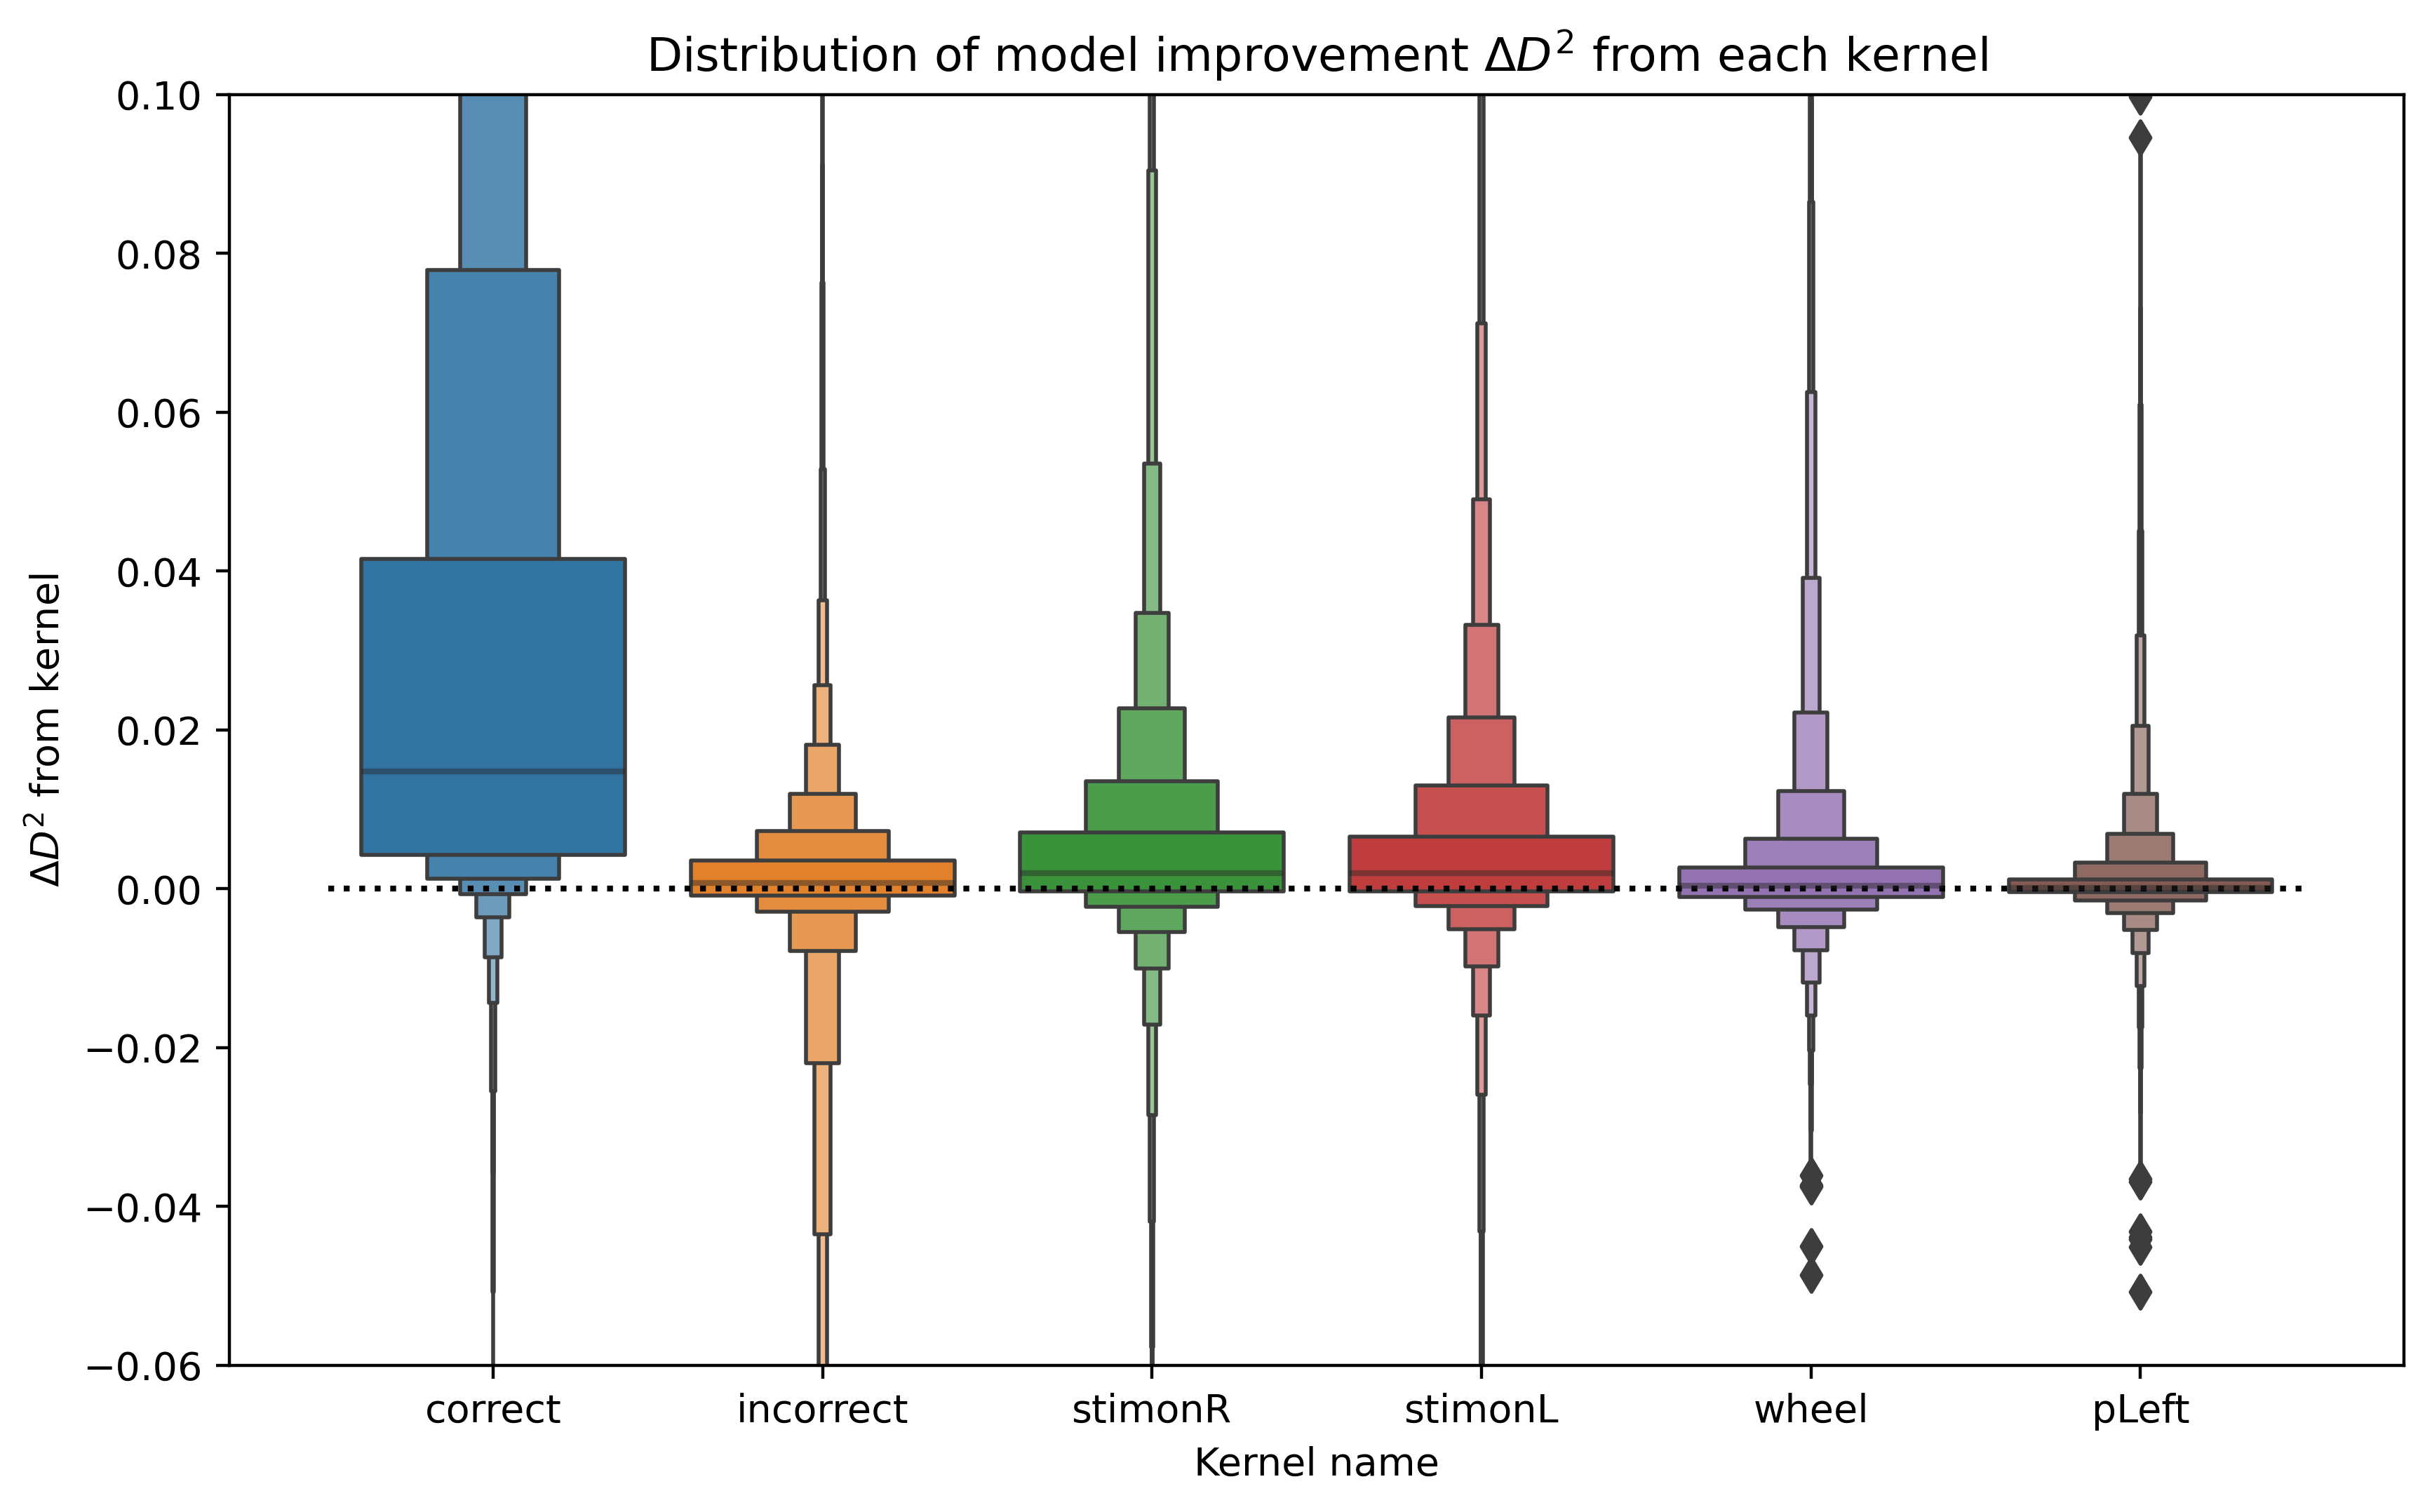

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=400)
sns.boxenplot(data=topreg_melt, x='covname', y='value',
            order=['correct', 'incorrect', 'stimonR', 'stimonL', 'wheel', 'pLeft'], # fliersize=0,
            ax=ax,
            # cut=0, inner='quartiles',
            )
ax.set_ylabel('$\Delta D^2$' + ' from kernel')
ax.set_xlabel('Kernel name')
ax.set_title('Distribution of model improvement $\Delta D^2$ from each kernel')
ax.set_ylim([-0.06, 0.1])
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color='k', ls=':')

In [73]:
masterscores[masterscores.nolayer_name == 'Anterior cingulate area dorsal part'].origfn.value_counts()

36    65
1     46
Name: origfn, dtype: int64

In [17]:
from oneibl import one
one=one.ONE()
sessdict = list(filedata.values())[1]
sessdate = str(sessdict['sessinfo']['session_start_time'].date())
ids = one.search(subject=sessdict['sessinfo']['subject_nickname'], date_range=[sessdate, sessdate])
spikes = one.load(ids[0], 'spikes.times', offline=True)

Connected to https://alyx.internationalbrainlab.org as berk.gercek


In [74]:
print(sessuuids[36])
print(orig_fns[36])

259927fd-7563-4b03-bc5d-17b4d0fa7a55
./fits/ZM_2240/2020-01-22_session_2020-10-26_probe0_fit.p


In [98]:
from brainbox.io.one import load_spike_sorting_with_channel
from export_funs import trialinfo_to_df
target_sessions = {'Primary vis': {'uuid': 'b52182e7-39f6-4914-9717-136db589706e', 'probe': 'probe00'},
                   'Primary motor': {'uuid': '7bee9f09-a238-42cf-b499-f51f765c6ded', 'probe': 'probe00'},
                   'Secondary motor': {'uuid': '4d8c7767-981c-4347-8e5e-5d5fffe38534', 'probe': 'probe01'},
                   'Anterior cingulate area dorsal part': {'uuid': '259927fd-7563-4b03-bc5d-17b4d0fa7a55',
                                                           'probe': 'probe00'},}

data = {}
for region in target_sessions:
    data[region] = {}
    uuid = target_sessions[region]['uuid']
    spikes, clusters, _ = load_spike_sorting_with_channel(uuid)
    data[region]['uuid'] = uuid
    data[region]['spike_times'] = spikes[target_sessions[region]['probe']].times
    data[region]['spike_clusters'] = spikes[target_sessions[region]['probe']].clusters
    data[region]['brain_region'] = clusters[target_sessions[region]['probe']].acronym
    data[region]['trialsdf'] = trialinfo_to_df(uuid, maxlen=2., ret_wheel=True)

Connected to https://alyx.internationalbrainlab.org as berk.gercek


2020-10-30 11:48:36.128 INFO     [one.py:107] Channel locations for probe00 have not been resolved. Channel and cluster locations obtained from histology track.


Connected to https://alyx.internationalbrainlab.org as berk.gercek


2020-10-30 11:48:37.495 INFO     [one.py:107] Channel locations for probe01 have not been resolved. Channel and cluster locations obtained from histology track.


Connected to https://alyx.internationalbrainlab.org as berk.gercek


2020-10-30 11:49:09.881 WARNING  [one.py:750]  local md5 or size mismatch, re-downloading /media/berk/Storage1/flatiron/danlab/Subjects/DY_011/2020-01-31/001/alf/probe00/spikes.times.npy


Downloading: /media/berk/Storage1/flatiron/danlab/Subjects/DY_011/2020-01-31/001/alf/probe00/spikes.times.b60acbac-bd92-488e-918d-7cd2ff5bd8eb.npy Bytes: 37658064


2020-10-30 11:49:12.756 INFO     [one.py:107] Channel locations for probe00 have not been resolved. Channel and cluster locations obtained from histology track.


Connected to https://alyx.internationalbrainlab.org as berk.gercek
Connected to https://alyx.internationalbrainlab.org as berk.gercek


2020-10-30 11:49:37.857 INFO     [one.py:107] Channel locations for probe01 have not been resolved. Channel and cluster locations obtained from histology track.


Connected to https://alyx.internationalbrainlab.org as berk.gercek


2020-10-30 11:49:39.156 INFO     [one.py:107] Channel locations for probe00 have not been resolved. Channel and cluster locations obtained from histology track.


Connected to https://alyx.internationalbrainlab.org as berk.gercek


2020-10-30 11:50:15.895 INFO     [one.py:107] Channel locations for probe00 have not been resolved. Channel and cluster locations obtained from histology track.


Connected to https://alyx.internationalbrainlab.org as berk.gercek


2020-10-30 11:50:17.181 INFO     [one.py:107] Channel locations for probe01 have not been resolved. Channel and cluster locations obtained from histology track.


In [81]:
fw = open('/home/berk/Documents/four_recordings_for_comparison.p', 'wb')
pickle.dump(data, fw)
fw.close()

In [96]:
trialsdf = data['Anterior cingulate area dorsal part']['trialsdf'].probabilityLeft
test = np.argwhere(np.diff(data['Anterior cingulate area dorsal part']['trialsdf'].probabilityLeft))
test2 = test[1:] - test[:-1]

7
